In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as st

In [2]:
# Constants
CONSTANT_lL = 0.15
CONSTANT_Ld95 = 30

CONSTANT_ma = 0.015
CONSTANT_mr = 4.2
CONSTANT_mt = 2.75

CONSTANT_Cf = 0.5
CONSTANT_Cg = 0.25

In [3]:
def get_l_factor(L=CONSTANT_lL, d95=CONSTANT_Ld95):
    """Returns the l factor

    Args:
        L (float, optional): liberation size in cm, 150 microns from p80 of rougher flotation feed. 
        Assume as p80 of the rougher floation feed. Defaults to 0.15.
        d95 (int, optional): 95% passing in cm. Bern estimates 30 cm - 100 cm. Defaults to 30.

    Returns:
        float: l_factor
    """
    return np.sqrt(L / d95)

def get_m_factor(a=CONSTANT_ma, r=CONSTANT_mr, t=CONSTANT_mt):
    """Returns the m factor

    Args:
        a (float, optional): average grade as a decimal. Defaults to 0.015 (1.5%).
        r (float, optional): mineral density. Use the density for chalcopyrite. Defaults to 4.2.
        t (float, optional): gangue density. From the Minesense Amenability Study Table 1. Defaults to 2.75.

    Returns:
        _type_: _description_
    """
    return (1 - a) / a * ((1 - a) * r + a * t)

def get_C_factor(f=CONSTANT_Cf, g=CONSTANT_Cg, l=get_l_factor(), m=get_m_factor()):
    """returns C factor from params f, g, l, m

    Args:
        f (float, optional): f factor, 0.5 for non-gold. 0.2 for gold. Defaults to 0.5.
        g (float, optional): g factor, as size ration increases, g decreases. Defaults to 0.25.
        l (float, optional): l factor. Defaults to get_l_factor().
        m (float, optional): m factor. Defaults to get_m_factor().

    Returns:
        float: returns the C factor
    """
    return f * g * l * m

def sigmas_from_conf(conf):
    """returns the number of standard deviations from the mean with a given confidence interval
    i.e. with a 95% conf interval (conf = 0.95), function will return 1.96, meaning a 95% confidence that the
    value is at most 1.96 stds (Z) away from the mean.

    Args:
        conf (float): confidence interval as a decimal

    Returns:
        float: number of stds away from the mean the actual value is away from the calculated value within the given confindence interval
    """
    return st.norm.ppf(1 - (1 - conf) / 2)

def sigma_from_params(conf_int, conf_range, grade):
    """Returns the value of sigma given a confidence interval, range, and average grade. This value can be fed into other 
    formulas to determine the minimum sample size.

    Args:
        conf_int (float): Confidence interval as a decimal percentage: 95% is 0.95
        conf_range (float): Range for the given confidence interval: 95% confident that the value is within 0.2% of the true value
        grade (float): Average grade of the distribution

    Returns:
        float: A sigma value: sigma = 0.01 (i.e. 1% error)
    """
    return (conf_range / grade) / sigmas_from_conf(conf_int)

def sample_mass_from_params(C, d95, sigma):
    """Return the minimum sample mass (in grams) to achieve the required degree of confidence & other errors associated

    Args:
        C (float): C value in g/cm^3
        d95 (float): 95% passing size of the distribution in cm
        sigma (float): sigma value

    Returns:
        _type_: _description_
    """
    return C * d95**3 / sigma**2

In [4]:
get_C_factor()

2.4251265623877516

In [5]:
Ms = 30 # kg
variation = get_C_factor() / Ms
sigma = np.sqrt(variation)

In [6]:
sigma

0.2843194542756294

In [7]:
1.5 * (sigma / 2)  

0.21323959070672205

In [8]:
st.norm.cdf(sigma)

0.61191721064182

In [9]:
sigmas_from_conf(0.95)

1.959963984540054

In [10]:
d = .30
(get_C_factor() * (d**3)) / (sigmas_from_conf(0.90) ** 2)

0.0242015766131399

In [11]:
(get_C_factor() * 30**3) / sigmas_from_conf(0.90)

39808.05107006709

# Sample Calculation

Consider a copper ore, assaying ~ 1.5 % Cu, which must be routinely sampled on crusher product for assay to a 90% confidence level of +/- 0.1% Cu. 


In [12]:
# Solution
# Relative precision sigma in relative terms is calculated from :
#    X * sigma {or the confidence interval, x = ~2 if confidendence interval is 95%} = deviation from mean / mean percentage
# 1.96 sigma = 0.1 % / 1.5% in the example above

confidence_level = 0.90 # * 100%
confidence_range = 0.15 # %
average_grade = 1.5 # %

sigma = (confidence_range / average_grade) / sigmas_from_conf(confidence_level)
sigma

0.06079568319117691

In [13]:
d95 = 30
C = get_C_factor(
    f=0.5,
    g=0.25,
    l=get_l_factor(
        L=0.15,
        d95=d95
    ),
    m=get_m_factor(
        a=0.015,
        r=4.2,
        t=2.75
    )
)

mass_in_grams = sample_mass_from_params(C, d95, sigma)
print(f'{mass_in_grams / 1000:0.2f} kgs')

17715.47 kgs


In [14]:
d95 = 2.5
sigma = sigma_from_params(0.95, 0.1, 5)
C = get_C_factor(
    f=0.5,
    g=0.25,
    l=get_l_factor(
        L=0.015,
        d95=d95
    ),
    m=get_m_factor(
        a=0.058,
        r=7.6,
        t=2.65
    )
)
mass_in_grams = sample_mass_from_params(C, d95, sigma)
mass_in_grams / 1000

172.56566877250697

## Calculations

Test a variety of different precision and confidence intervals in addition to modifying assumed values slightly

In [15]:
# Can vary confidence level, starting at 95% and decreasing
# An average grade of 1.5% Cu remains unchanged, however the confidence range can change.
# While the precision of minesense is said to be quite high, accuracy matters much more, and we can see the estimated minimum sample size
# for various ranges of confidence. Start at 0.1% Cu and increase

confidence_level = 0.90 # * 100%
confidence_range = 0.15 # %
average_grade = 1.5 # %

sigma = (confidence_range / average_grade) / sigmas_from_conf(confidence_level)
sigma

0.06079568319117691

In [16]:
d95 = 30 # 95 % passing of the lot in cm, can vary from 10 cm - 100 cm
C = get_C_factor(
    f=0.5, # Does not vary
    g=0.25, # Should not vary
    l=get_l_factor(
        L=0.15, # Liberation size in cm. Can attempt to vary from 0.1-0.2
        d95=d95
    ),
    m=get_m_factor(
        a=0.015, # Average grade, should not change from 1.5%
        r=4.2, # SG of mineral, should remain the same, but could vary from 4.1-4.2
        t=2.75 # SG of gangue, should remain the same, but could try varying from 2.7-2.8
    )
)

mass_in_grams = sample_mass_from_params(C, d95, sigma)
print(f'{mass_in_grams / 1000:0.2f} kgs')

17715.47 kgs


In [17]:
confidence_levels = [0.95, 0.9, 0.85, 0.8, 0.75] # *100%
confidence_ranges = [0.1, 0.15, 0.2] # %
average_grade = 1.5

sigmas = []
for confidence_level in confidence_levels:
    for confidence_range in confidence_ranges:
        sigmas.append(sigma_from_params(confidence_level, confidence_range, average_grade))

In [18]:
d95s = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Cs = []
for d95 in d95s:
    Cs.append(get_C_factor(
        f=0.5, # Does not vary
        g=0.25, # Should not vary
        l=get_l_factor(
            L=0.15, # Liberation size in cm. Can attempt to vary from 0.1-0.2
            d95=d95
        ),
        m=get_m_factor(
            a=0.015, # Average grade, should not change from 1.5%
            r=4.2, # SG of mineral, should remain the same, but could vary from 4.1-4.2
            t=2.75 # SG of gangue, should remain the same, but could try varying from 2.7-2.8
        )
    ))

sample_sizes = []

        
for C in Cs:
    for d95 in d95s:
        for sigma in sigmas:
            sample_sizes.append(sample_mass_from_params(C, d95, sigma) / 1e6)

In [19]:
pd.Series(sample_sizes).describe()

count    1500.000000
mean      187.854892
std       314.285144
min         0.098873
25%        11.254296
50%        69.697215
75%       225.963898
max      3630.560982
dtype: float64

## Dataframed

In [119]:
columns = [
    'confidence_level', 
    'confidence_range',
    'average_grade',
    'sigma',
    'd95',
    'f',
    'g',
    'lL',
    'ma',
    'mr',
    'mt',
    'min_sample_size'
    ]
data = []

confidence_levels = [0.95, 0.9, 0.85, 0.8, 0.75] # *100%
confidence_ranges = [0.05, 0.1, 0.15, 0.2] # %
average_grade = 1.5
d95s = np.arange(10, 102, 2)  # 25-75 cm?
# [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lLs = [0.1, 0.15, 0.2]
mrs = [4.1, 4.15, 4.2]
mts = [2.7, 2.75, 2.8]

In [149]:
confidence_levels = [0.9] # *100%
confidence_ranges = [0.1, 0.05] # %
average_grade = 1.5
d95s = [50, 100]
# [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lLs = [.15]
mrs = [4.15]
mts = [2.75]

In [150]:
data = []
for L in lLs:
    for r in mrs:
        for t in mts:
            for d95 in d95s:
                C = get_C_factor(
                    f=CONSTANT_Cf, # Does not vary, set at 0.5
                    g=0.25, # Should not vary, set at 0.25
                    l=get_l_factor(
                        L=L, # Liberation size in cm. Can attempt to vary from 0.1-0.2
                        d95=d95
                    ),
                    m=get_m_factor(
                        a=0.015, # Average grade, should not change from 1.5%
                        r=r, # SG of mineral, should remain the same, but could vary from 4.1-4.2
                        t=t # SG of gangue, should remain the same, but could try varying from 2.7-2.8
                    )
                )
                for confidence_level in confidence_levels:
                    for confidence_range in confidence_ranges:
                        sigma = sigma_from_params(confidence_level, confidence_range, average_grade)
                        sample_size = sample_mass_from_params(C, d95, sigma) / 1e6
                        
                        data.append([
                            confidence_level,
                            confidence_range,
                            average_grade,
                            sigma,
                            d95,
                            CONSTANT_Cf,
                            CONSTANT_Cg,
                            L, # L
                            0.015, # a
                            r, # r
                            t, # t
                            sample_size
                        ])                
            
df = pd.DataFrame(data, columns=columns)
df

,confidence_level,confidence_range,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
0,0.9,0.10,1.5,0.040530,50,0.5,0.25,0.15,0.015,4.15,2.75,141.256207
1,0.9,0.05,1.5,0.020265,50,0.5,0.25,0.15,0.015,4.15,2.75,565.024827
2,0.9,0.10,1.5,0.040530,100,0.5,0.25,0.15,0.015,4.15,2.75,799.065773
3,0.9,0.05,1.5,0.020265,100,0.5,0.25,0.15,0.015,4.15,2.75,3196.263092


In [94]:
df['min_sample_size'].describe()

count      1.000000
mean     565.024827
std             NaN
min      565.024827
25%      565.024827
50%      565.024827
75%      565.024827
max      565.024827
Name: min_sample_size, dtype: float64

In [95]:
df[df['min_sample_size'] <= 15].describe()

,confidence_level,confidence_range,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'confidence_level'}>,
        <AxesSubplot:title={'center':'confidence_range'}>],
       [<AxesSubplot:title={'center':'d95'}>,
        <AxesSubplot:title={'center':'min_sample_size'}>]], dtype=object)

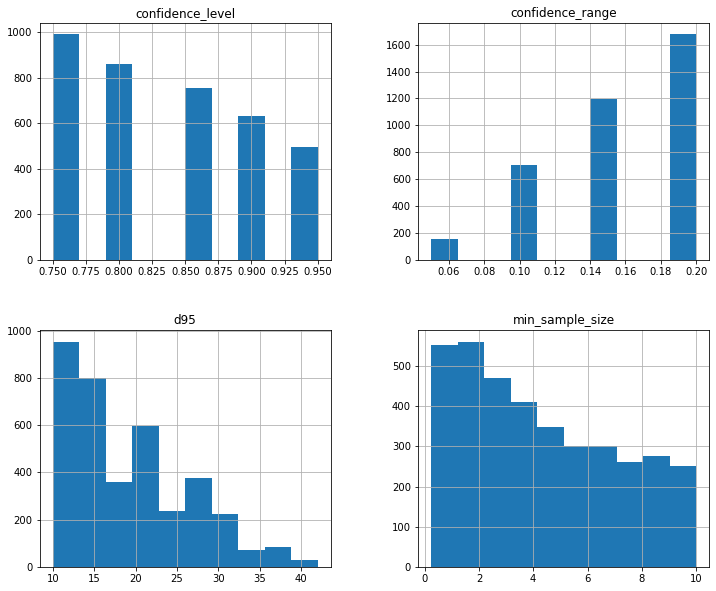

In [136]:
df[
    df['min_sample_size'] <= 10
][[
    'confidence_level',
    'confidence_range',
    'd95',
    'min_sample_size'
]].hist(figsize=(12, 10))

In [97]:
df[df['min_sample_size'] <= 2.5].describe()

,confidence_level,confidence_range,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Reverse

In [142]:
r_sigmas, r_zs, r_crs = [], [], []
Ms = [25000, 30000, 35000]

for C in Cs:
    for m in Ms:
        for d95 in d95s:
            sigma = np.sqrt(C * d95**3 / (m / 2))  # divide by two bc the min sample size is usually half of the suggested
            r_sigmas.append(sigma)
            z = 0.05 / (1.5 * sigma)  # within 0.2% Cu
            r_zs.append(z)
            r_crs.append((st.norm.cdf(z) - 0.5) * 2)

In [145]:
data = []
for L in lLs:
    for r in mrs:
        for t in mts:
            for d95 in d95s:
                C = get_C_factor(
                    f=CONSTANT_Cf, # Does not vary, set at 0.5
                    g=0.25, # Should not vary, set at 0.25
                    l=get_l_factor(
                        L=L, # Liberation size in cm. Can attempt to vary from 0.1-0.2
                        d95=d95
                    ),
                    m=get_m_factor(
                        a=0.015, # Average grade, should not change from 1.5%
                        r=r, # SG of mineral, should remain the same, but could vary from 4.1-4.2
                        t=t # SG of gangue, should remain the same, but could try varying from 2.7-2.8
                    )
                )
                for m in Ms:
                    sigma = np.sqrt(C * d95**3 / (m / 2))  # divide by two bc the min sample size is usually half of the suggested
                    z = 0.2 / (1.5 * sigma)  # within 0.2% Cu
                        
                    data.append([
                        (st.norm.cdf(z) - 0.5) * 2,
                        0.2,
                        average_grade,
                        sigma,
                        d95,
                        CONSTANT_Cf,
                        CONSTANT_Cg,
                        L, # L
                        0.015, # a
                        r, # r
                        t, # t
                        m / (2 * 1e6)
                    ])   
                    
r_df = pd.DataFrame(data, columns=columns)

In [146]:
r_df

,confidence_level,confidence_range,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
0,0.046732,0.2,1.5,2.275199,30,0.5,0.25,0.15,0.015,4.15,2.75,0.0125
1,0.051186,0.2,1.5,2.076963,30,0.5,0.25,0.15,0.015,4.15,2.75,0.0150
2,0.055281,0.2,1.5,1.922894,30,0.5,0.25,0.15,0.015,4.15,2.75,0.0175
3,0.024688,0.2,1.5,4.308541,50,0.5,0.25,0.15,0.015,4.15,2.75,0.0125
4,0.027043,0.2,1.5,3.933142,50,0.5,0.25,0.15,0.015,4.15,2.75,0.0150
5,0.029209,0.2,1.5,3.641382,50,0.5,0.25,0.15,0.015,4.15,2.75,0.0175


In [100]:
st.norm.cdf(0.75)

0.7733726476231317

In [26]:
1-st.norm.cdf(0.350643)

0.36292809644588064

In [101]:
pd.Series(r_crs).describe()

count    30.000000
mean      0.006637
std       0.001184
min       0.004104
25%       0.005832
50%       0.006794
75%       0.007498
max       0.008634
dtype: float64

<AxesSubplot:>

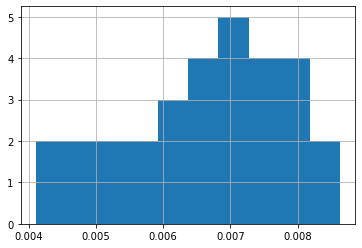

In [102]:
pd.Series(r_crs).hist()

array([[<AxesSubplot:title={'center':'confidence_level'}>,
        <AxesSubplot:title={'center':'confidence_range'}>,
        <AxesSubplot:title={'center':'average_grade'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'d95'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'lL'}>,
        <AxesSubplot:title={'center':'ma'}>],
       [<AxesSubplot:title={'center':'mr'}>,
        <AxesSubplot:title={'center':'mt'}>,
        <AxesSubplot:title={'center':'min_sample_size'}>]], dtype=object)

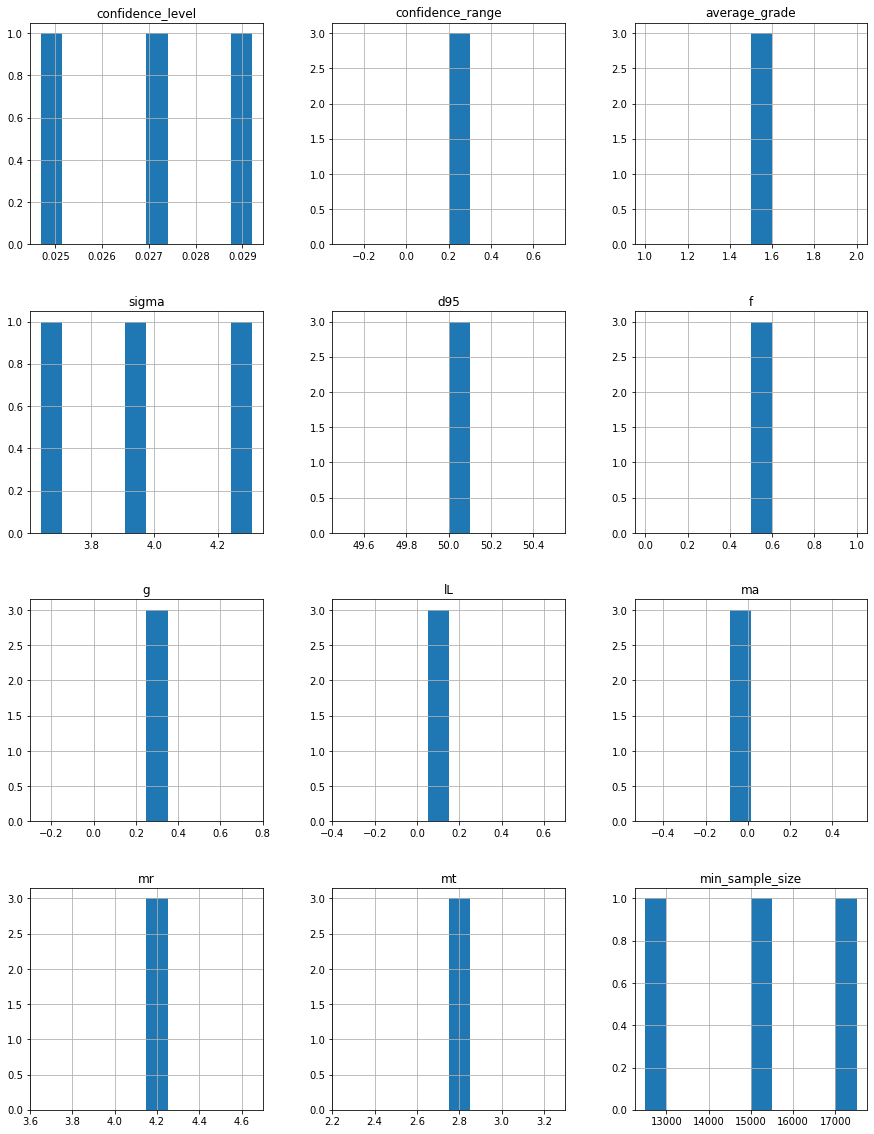

In [103]:
r_df.hist(figsize=(15, 20))

In [104]:
r_df.describe()

,confidence_level,confidence_range,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
count,3.000000,3.000000e+00,3.0,3.000000,3.0,3.0,3.00,3.00,3.000,3.00,3.00,3.0
mean,0.026980,2.000000e-01,1.5,3.961022,50.0,0.5,0.25,0.15,0.015,4.15,2.75,15000.0
std,0.002261,3.399350e-17,0.0,0.334452,0.0,0.0,0.00,0.00,0.000,0.00,0.00,2500.0
min,0.024688,2.000000e-01,1.5,3.641382,50.0,0.5,0.25,0.15,0.015,4.15,2.75,12500.0
25%,0.025865,2.000000e-01,1.5,3.787262,50.0,0.5,0.25,0.15,0.015,4.15,2.75,13750.0
50%,0.027043,2.000000e-01,1.5,3.933142,50.0,0.5,0.25,0.15,0.015,4.15,2.75,15000.0
75%,0.028126,2.000000e-01,1.5,4.120842,50.0,0.5,0.25,0.15,0.015,4.15,2.75,16250.0
max,0.029209,2.000000e-01,1.5,4.308541,50.0,0.5,0.25,0.15,0.015,4.15,2.75,17500.0


In [105]:
r_df[r_df['confidence_level'] == r_df['confidence_level'].max()]

,confidence_level,confidence_range,average_grade,sigma,d95,f,g,lL,ma,mr,mt,min_sample_size
2,0.029209,0.2,1.5,3.641382,50,0.5,0.25,0.15,0.015,4.15,2.75,17500.0
